In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 30 19:56:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data/46985"
tsvData = os.path.join(dataDir,"WoSDataset_46985.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(46985, 4)


In [7]:
print(tsvData[0:10])

[['0' 'CS'
  ' 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction        '
  '2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional two solitons are seen inf

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6514  4237  5483  3297 14625  7142  5687]


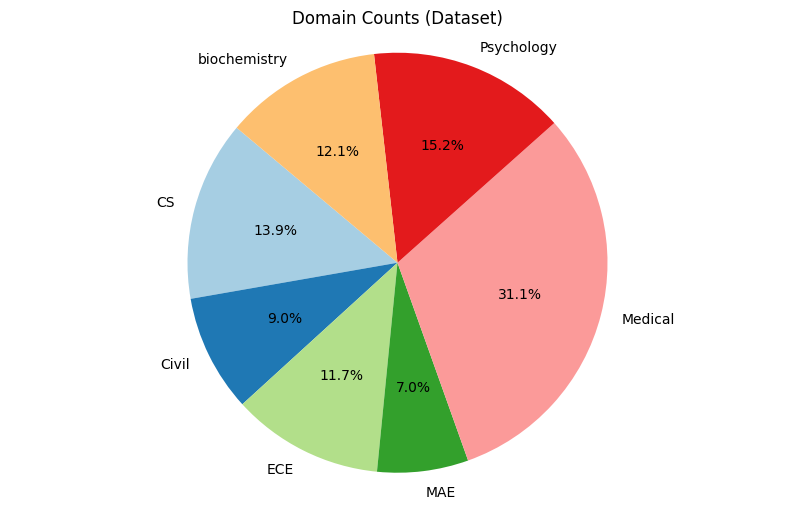

The domain CS has 6514 records in the dataset.
The domain Civil has 4237 records in the dataset.
The domain ECE has 5483 records in the dataset.
The domain MAE has 3297 records in the dataset.
The domain Medical has 14625 records in the dataset.
The domain Psychology has 7142 records in the dataset.
The domain biochemistry has 5687 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  46985
Shape of abstracts:  (46985,)
['hydromechanical compensators are often integrated with pistontype pumps to produce various control behavior for example pressure loadsensing power or torque control various hydromechanical mechanisms eg spring forces and load pressure are found in the industry to ensure the desired effect of the system outputs swash angle discharge pressure and input torque following the reference inputs in a companion paper part i of this paper a generic linearized statespace model is derived to investigate the pump dynamics and determine the design criteria and parameters in the study the statespace equations are used to propose and define the generic compensating control pump to conduct the similar strategies as hydromechanical pumps do the different control purposes pressureflowpower compensating are accomplished by only manipulating the generic regulate inputs given by an electrical proportional control valve in the opencircuit pump the g

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

(37588, 4)
(9397, 4)
(37588, 4)
(9397, 4)
(1880, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  37588
Shape of abstracts:  (37588,)
Number of keywords:  37588
Shape of keywords:  (37588,)
Number of domains:  37588
Shape of domains:  (37588,)
Number of labels:  37588
Shape of labels:  (37588,)
['according to cognitive theories of personality disorders antisocial personality disorder aspd is based upon a distinct set of cognitivebehavioral representations the aim of this study is to examine this supposition by comparing the early maladaptive schemas emss and core beliefs of young antisocial men with those of a set of sociodemographically matched psychiatrically healthy individuals we used the schema questionnaire sqsf and the social comparison scale scs to identify and evaluate subjects emss and core beliefs thirtyeight antisocial individuals and 24 healthy control subjects participated in the study results of the scs indicated that antisocial patients see themselves as unlovable lonely and rejected results of the sqsf indicated that antisocial patients had si

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 5170  3425  4361  2637 11669  5757  4569]


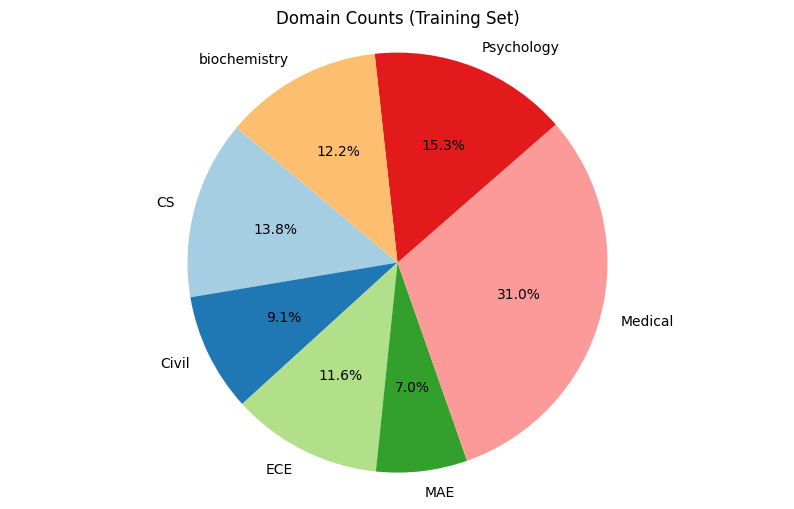

The domain CS has 5170 records in the training set.
The domain Civil has 3425 records in the training set.
The domain ECE has 4361 records in the training set.
The domain MAE has 2637 records in the training set.
The domain Medical has 11669 records in the training set.
The domain Psychology has 5757 records in the training set.
The domain biochemistry has 4569 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  9397
Shape of abstracts:  (9397,)
Number of keywords:  9397
Shape of keywords:  (9397,)
Number of domains:  9397
Shape of domains:  (9397,)
Number of labels:  9397
Shape of labels:  (9397,)
['in terms of capturing software requirements the most appropriate elicitation technique must be selected but what does this mean this paper makes a comparison between what researchers and software engineers see as adequate technique for capturing relevant information to meet software requirements a systematic mapping of constructs which researchers define as good techniques is presented and compared with practitioners opinions the study identified 13 constructs that were finally whittled down to six the software engineers survey showed no significant difference between these constructs this work demonstrates the divergence of views between researchers and practitioners about the quality of software requirement elicitation techniques the results call for more empirical research

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1344  812 1122  660 2956 1385 1118]


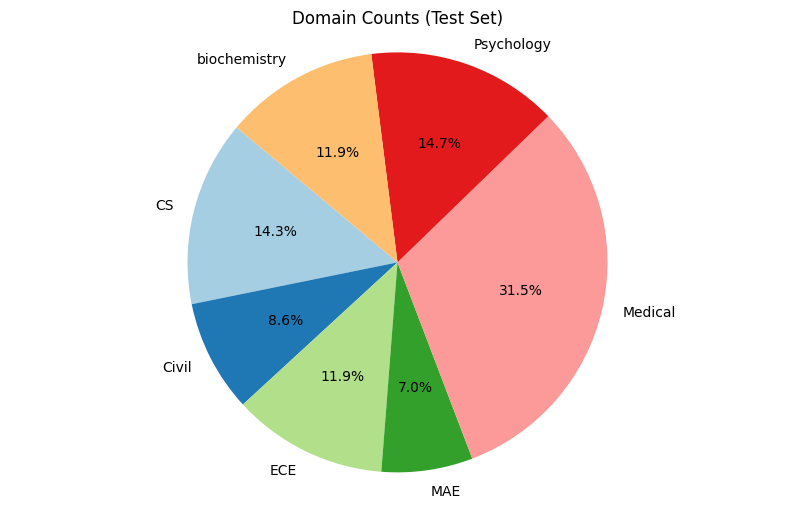

The domain CS has 1344 records in the test set.
The domain Civil has 812 records in the test set.
The domain ECE has 1122 records in the test set.
The domain MAE has 660 records in the test set.
The domain Medical has 2956 records in the test set.
The domain Psychology has 1385 records in the test set.
The domain biochemistry has 1118 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  1880
Shape of abstracts:  (1880,)
Number of keywords:  1880
Shape of keywords:  (1880,)
Number of domains:  1880
Shape of domains:  (1880,)
Number of labels:  1880
Shape of labels:  (1880,)
['hazard assessment of chemical contaminants often relies on short term or partial lifecycle ecotoxicological tests while the impact of low dose throughout the entire life cycle of species across multiple generations has been neglected this study aimed at identifying the individual and populationlevel consequences of chronic water contamination by environmental concentrations of three organic micropollutants ibuprofen bisphenol a and benzoapyrene on aedes aegypti mosquito populations in experimental conditions lifehistory assays spanning the full lifecycle of exposed individuals and their progeny associated with population dynamics modelling evidenced lifehistory traits alterations in unexposed progenies of individuals chronically exposed to 1 a ibuprofen or 06 a benzoapyrene t

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [240 164 226 131 612 287 220]


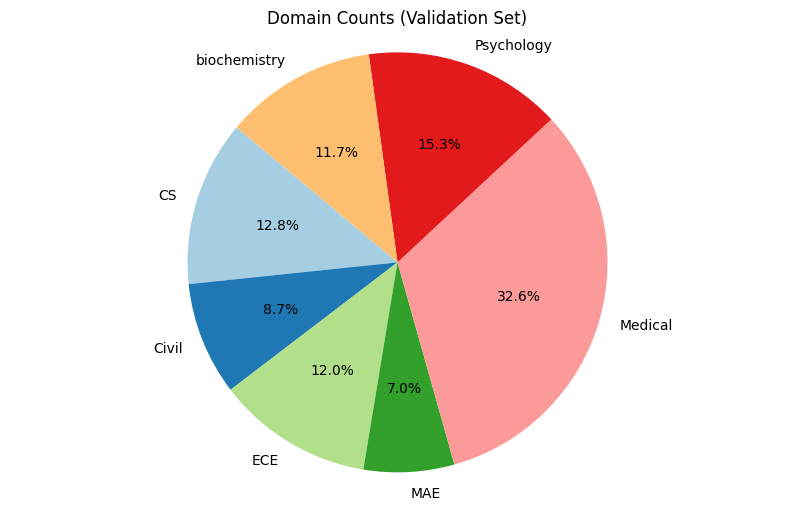

The domain CS has 240 records in the vaidation set.
The domain Civil has 164 records in the vaidation set.
The domain ECE has 226 records in the vaidation set.
The domain MAE has 131 records in the vaidation set.
The domain Medical has 612 records in the vaidation set.
The domain Psychology has 287 records in the vaidation set.
The domain biochemistry has 220 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstracts 3
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(37588, 4)
(9397, 4)
(1880, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  37588
Label length  1880
Label length  9397


In [22]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 1175/1175 [12:28<00:00,  1.57batch/s]


Epoch 1/20
  Train Loss: 0.6271102565526963
  Val Micro F1: 0.8462765957446808
  Time: 12m 41s


Epoch 2/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 2/20
  Train Loss: 0.3797426591433109
  Val Micro F1: 0.8643617021276596
  Time: 12m 43s


Epoch 3/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 3/20
  Train Loss: 0.28140428561479486
  Val Micro F1: 0.8590425531914894
  Time: 12m 43s


Epoch 4/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 4/20
  Train Loss: 0.19690394586071056
  Val Micro F1: 0.8617021276595744
  Time: 12m 43s


Epoch 5/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 5/20
  Train Loss: 0.13403504869286367
  Val Micro F1: 0.8537234042553191
  Time: 12m 43s


Epoch 6/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 6/20
  Train Loss: 0.09148467919283963
  Val Micro F1: 0.8553191489361702
  Time: 12m 43s


Epoch 7/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 7/20
  Train Loss: 0.06313561163733694
  Val Micro F1: 0.8547872340425532
  Time: 12m 43s


Epoch 8/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 8/20
  Train Loss: 0.044018024267267156
  Val Micro F1: 0.8542553191489362
  Time: 12m 43s


Epoch 9/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 9/20
  Train Loss: 0.0345904163616967
  Val Micro F1: 0.8553191489361702
  Time: 12m 44s


Epoch 10/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 10/20
  Train Loss: 0.02688158534122928
  Val Micro F1: 0.8531914893617021
  Time: 12m 43s


Epoch 11/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 11/20
  Train Loss: 0.01929750756878886
  Val Micro F1: 0.8547872340425532
  Time: 12m 43s


Epoch 12/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 12/20
  Train Loss: 0.014075637185141727
  Val Micro F1: 0.8515957446808511
  Time: 12m 43s


Epoch 13/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 13/20
  Train Loss: 0.012160982807535936
  Val Micro F1: 0.8558510638297873
  Time: 12m 43s


Epoch 14/20: 100%|██████████| 1175/1175 [12:31<00:00,  1.56batch/s]


Epoch 14/20
  Train Loss: 0.008006341352799047
  Val Micro F1: 0.8638297872340426
  Time: 12m 43s


Epoch 15/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 15/20
  Train Loss: 0.009352130547919474
  Val Micro F1: 0.8515957446808511
  Time: 12m 43s


Epoch 16/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.57batch/s]


Epoch 16/20
  Train Loss: 0.005971955226502379
  Val Micro F1: 0.8595744680851064
  Time: 12m 42s


Epoch 17/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.57batch/s]


Epoch 17/20
  Train Loss: 0.005358377789212837
  Val Micro F1: 0.8590425531914894
  Time: 12m 42s


Epoch 18/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.57batch/s]


Epoch 18/20
  Train Loss: 0.001203425903779831
  Val Micro F1: 0.8622340425531915
  Time: 12m 42s


Epoch 19/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.57batch/s]


Epoch 19/20
  Train Loss: 0.0029416543482380184
  Val Micro F1: 0.8611702127659574
  Time: 12m 42s


Epoch 20/20: 100%|██████████| 1175/1175 [12:30<00:00,  1.56batch/s]


Epoch 20/20
  Train Loss: 0.001432861460713692
  Val Micro F1: 0.8606382978723405
  Time: 12m 43s


In [27]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1170   39   20   23   29   30   33]
 [  41  977    3   55   31   11    4]
 [  17    9 1162   10   10  157   20]
 [  26   32    5  541   35   11   10]
 [  26   18    8   17  732    6    5]
 [  14    5  179   16    8 2575  159]
 [  25    6   21    6    3  187  870]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1344
           1       0.90      0.87      0.88      1122
           2       0.83      0.84      0.84      1385
           3       0.81      0.82      0.81       660
           4       0.86      0.90      0.88       812
           5       0.86      0.87      0.87      2956
           6       0.79      0.78      0.78      1118

    accuracy                           0.85      9397
   macro avg       0.85      0.85      0.85      9397
weighted avg       0.85      0.85      0.85      9397

Macro F1 Score: 0.8496560142061885
Micro F1 Score: 0.8542087900393742
Weighted F1 Score: 0.8

In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/BERT_WoS_Abstracts_46985')

In [29]:
print('End of the runtime!')

End of the runtime!


In [30]:
runtime.unassign()